# Run and tumble particles with a velocity profile

In [1]:
%pylab inline
from itertools import cycle
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
mpl.rcParams.update(mpl.rcParamsDefault)

Populating the interactive namespace from numpy and matplotlib


## Input parameters

In [14]:
#Number of particles
N=100

#Particle velocity (left side of the box)
v0=0.5 #mu/s
#Particle velocity (right side of the box)
vf=10. #mu/s

#box size
box_x=100 #mu
box_y=100 #mu

#Total time
t_tot=100. #seg

#Time step
deltat=0.1 #seg

#Probability of tumble each second:
p_s=0.5


# Number of boxes when calculating the density (in both directions)
numboxes_x=40
numboxes_y=40

## Velocity profile of the particles

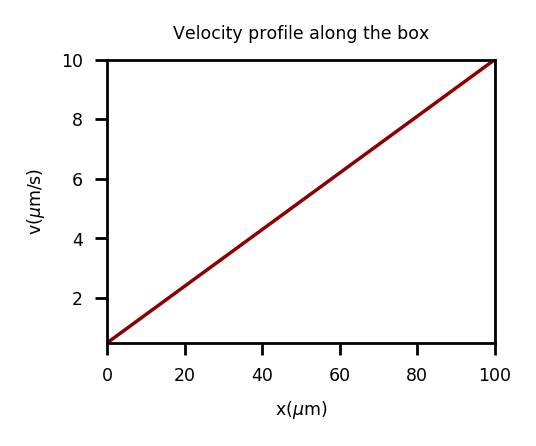

In [15]:
x_p = np.linspace(0,box_x,100) # 100 linearly spaced numbers
v_p = v0+x_p*(vf-v0)/box_x 

fig = plt.figure(figsize=(2,1.5),dpi=250)
ax = fig.add_subplot(111)

#size of font in graphs
mysize=5

plt.plot(x_p,v_p,linewidth=1,color='darkred')
ax.tick_params(labelsize=mysize)


plt.title( 'Velocity profile along the box', fontsize=mysize)            
plt.xlabel('x($\mu$m)',fontsize=mysize)
plt.ylabel('v($\mu$m/s)',fontsize=mysize)

plt.xlim(right=box_x,left=0)
plt.ylim(top=vf,bottom=v0)


plt.show()

## Let's create a grid to calculate densities (and draw it)

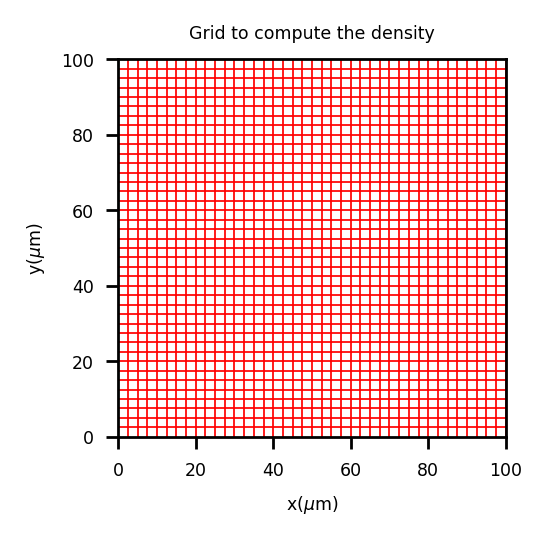

In [16]:
# sixe of boxes:
dr_x=box_x/numboxes_x
dr_y=box_y/numboxes_y


xb=np.zeros([numboxes_x+1])
yb=np.zeros([numboxes_y+1])


fig = plt.figure(figsize=(2,2),dpi=250)
ax = fig.add_subplot(111)
plt.xlim(right=box_x,left=0)
plt.ylim(top=box_y,bottom=0)
    
xb[0]=0.
yb[0]=0.

for i in range(1,numboxes_x+1):
    xb[i]=xb[i-1]+dr_x
    
    plt.plot([xb[i],xb[i]],[0,box_y],color='red',linewidth=0.5)
    
for i in range(1,numboxes_y+1):

    yb[i]=yb[i-1]+dr_y
    plt.plot([0,box_x],[yb[i],yb[i]],color='red',linewidth=0.5)

plt.title( 'Grid to compute the density', fontsize=mysize)            
plt.xlabel('x($\mu$m)',fontsize=mysize)
plt.ylabel('y($\mu$m)',fontsize=mysize)

plt.xlim(right=box_x,left=0)
plt.ylim(top=box_y,bottom=0)


ax.tick_params(labelsize=mysize)

plt.show()

### Function that calculates next position for particle at time ti
### And changes the velocity depending on where it is in x

In [17]:
def particulai(xik,yik,thetaik,ti,deltat,v0,p_tbl,box_x,box_y):
        
        #velocity according to position:
        v= v0+xik*(vf-v0)/box_x
        

        if np.less(np.random.random_sample(),p_tbl):
            thetanew=2*pi*np.random.random_sample()
            
        else:   
            thetanew=thetaik

        vx=v*np.cos(thetanew)
        vy=v*np.sin(thetanew)

        #v=np.sqrt(vx*vx+vy*vy)

        xnew=xik+vx*deltat
        ynew=yik+vy*deltat
        
        #PBC
        if (xnew)>box_x: 
            xnew=np.absolute(xnew-box_x)
        if (xnew)<0: 
            xnew=box_x-np.absolute(xnew)   
        if ynew>box_y:
            ynew=np.absolute(ynew-box_y)
        if (ynew)<0: 
            ynew=box_y-np.absolute(ynew)


        return xnew,ynew,thetanew

## Average density over time

In [18]:
def density_av(x,y,xb,yb,num_steps,numboxes_x,numboxes_y):
    count=np.zeros([numboxes_x,numboxes_y,num_steps])
    density=np.zeros([numboxes_x,numboxes_y,num_steps])

    for i in range(0,num_steps):
        for j in range(0,numboxes_x):
            for l in range(0,numboxes_y):
                for k in range(0,N):
                        if x[i,k]>xb[j] and x[i,k]<=xb[j+1] and y[i,k]>yb[l] and y[i,k]<=yb[l+1]:
                            count[j,l,i]=count[j,l,i]+1    

                density[j,l,i]=count[j,l,i]/(dr_x*dr_y)            
                densityav[j,l]=density[j,l,:].mean()

    return densityav

## Density in a certain instant

In [19]:
def densityi(xi,yi,xb,yb,num_steps,numboxes_x,numboxes_y):
    count=np.zeros([numboxes_x,numboxes_y])
    densityii=np.zeros([numboxes_x,numboxes_y])

    for j in range(0,numboxes_x):
        for l in range(0,numboxes_y):
            for k in range(0,N):
                        if xi[k]>xb[j] and xi[k]<=xb[j+1] and yi[k]>yb[l] and yi[k]<=yb[l+1]:
                            count[j,l]=count[j,l]+1    

    density_i=count/(dr_x*dr_y)            

        

    return density_i

## Main. It plots the trajectories

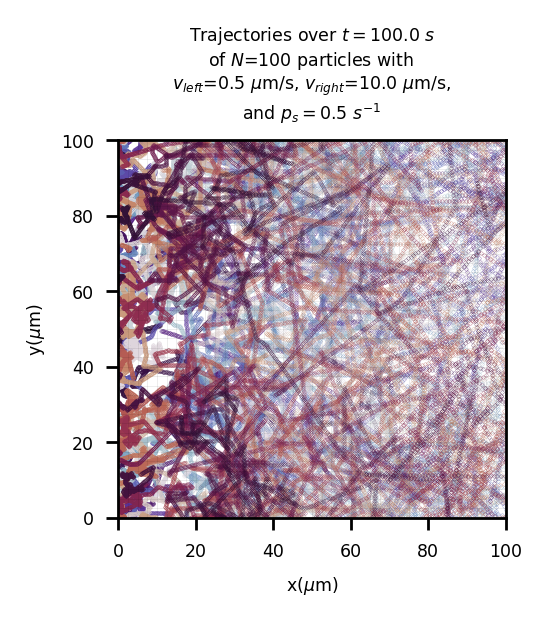

In [20]:
# Colormap. 
colors = plt.cm.twilight_shifted(np.linspace(0,1,N+1))


#Tumble probability each time step
p_tbl=p_s*deltat

#Number of time steps
num_steps=np.int(t_tot/deltat)+1


x=np.zeros([num_steps,N])
y=np.zeros([num_steps,N])
t=np.zeros([num_steps,1])
theta=np.zeros([num_steps,N])
dr_k=np.zeros([num_steps,N])

xi=np.zeros([N])
yi=np.zeros([N])
xold=np.zeros([N])
yold=np.zeros([N])

fp=np.zeros([1000])

t=deltat*np.arange(num_steps)

for k in range(0,N):
    x[0,k]=box_x*np.random.random_sample()
    y[0,k]=box_y*np.random.random_sample()
    theta[0,k]=2*pi*np.random.random_sample()    

for i in range(0,num_steps-1):
    
    for k in range(0,N):
    
        (x[i+1,k],y[i+1,k],theta[i+1,k])=particulai(x[i,k],y[i,k],theta[i,k],t[i],deltat,v0,p_tbl,box_x,box_y)
        
               
fig = plt.figure(figsize=(2,2),dpi=250)
ax = fig.add_subplot(111)    
    

plt.title( 'Trajectories over $t=$' + str(t_tot) + ' $s$ \n'
              'of $N$=' + str(N) + ' particles with \n'
              '$v_{left}$=' + str(v0) + ' $\mu$m/s, $v_{right}$=' + str(vf) + ' $\mu$m/s, \n'
                    'and $p_{s}=$' + str(p_s) + ' $s^{-1}$', fontsize=mysize)            
plt.xlabel('x($\mu$m)',fontsize=mysize)
plt.ylabel('y($\mu$m)',fontsize=mysize)
    
plt.xlim(right=box_x,left=0)
plt.ylim(top=box_y,bottom=0)
    
for k in range(0,N):   
    plt.scatter(x[:,k],y[:,k],color=colors[k],alpha=0.8,label='Particle ' + str(k+1),s=0.01)
    ax.tick_params(labelsize=mysize)



for j in range(1,numboxes_x): 
    plt.plot([xb[j],xb[j]],[0,box_y],color='black',alpha=0.1,linewidth=0.2)
    
for j in range(1,numboxes_y):
    plt.plot([0,box_x],[yb[j],yb[j]],color='black',alpha=0.1,linewidth=0.2)    
    
plt.show()



## Calculate the density of particles in the grid in the first and final frame 

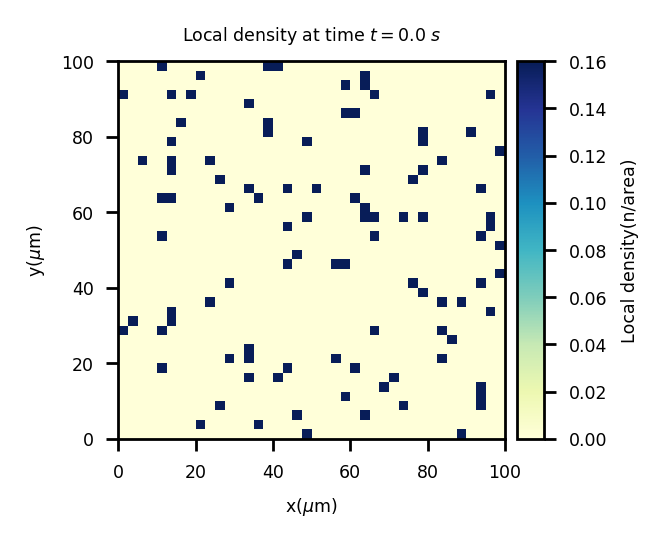

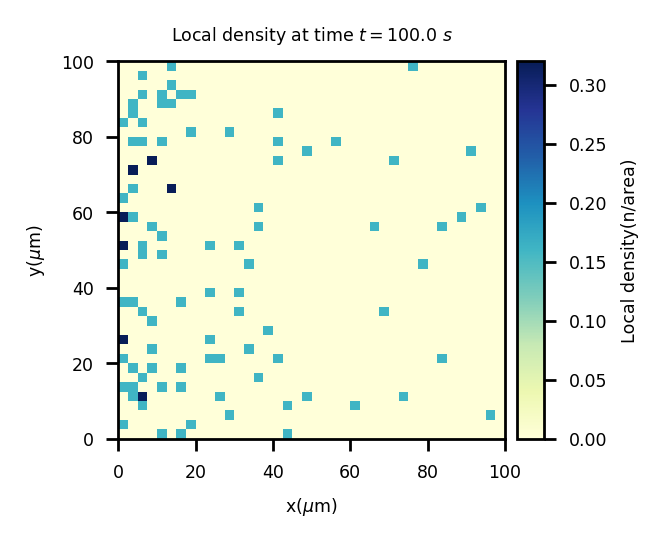

In [21]:
# Colormap. 
ncolors = 50
colors = plt.cm.YlGnBu(np.linspace(0,1,ncolors+1))
xi=np.zeros([N])
yi=np.zeros([N])

for i in [0,num_steps-1]:
    xi[:]=x[i,:]
    yi[:]=y[i,:]

    density_i=densityi(xi,yi,xb,yb,num_steps,numboxes_x,numboxes_y)
     
    N_maxd=np.max(density_i)                    

    fig = plt.figure(figsize=(2.2,2),dpi=250)
    ax = fig.add_subplot(111)

    plt.xlim(right=box_x,left=0)
    plt.ylim(top=box_y,bottom=0)

    ax.tick_params(labelsize=mysize)
    plt.xlabel('x($\mu$m)',fontsize=mysize)
    plt.ylabel('y($\mu$m)',fontsize=mysize)

    for n in range(0,numboxes_x):
        for h in range(0,numboxes_y):
                color_c=np.int(density_i[n,h]*ncolors/N_maxd)
                fill([xb[n],xb[n+1],xb[n+1],xb[n]], [yb[h],yb[h],yb[h+1],yb[h+1]], color=colors[color_c], alpha=1,linewidth=0)

    plt.title( 'Local density at time $t=$' + str(i*deltat) + ' $s$', fontsize=mysize)      

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="7%", pad=0.05)
    sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=0, vmax=N_maxd))
    cbar=plt.colorbar(sm,cax=cax)
    cbar.set_label(label='Local density(n/area)', size=mysize)
    cbar.ax.tick_params(labelsize=mysize)

    plt.show()

## We do an average of the density field over time

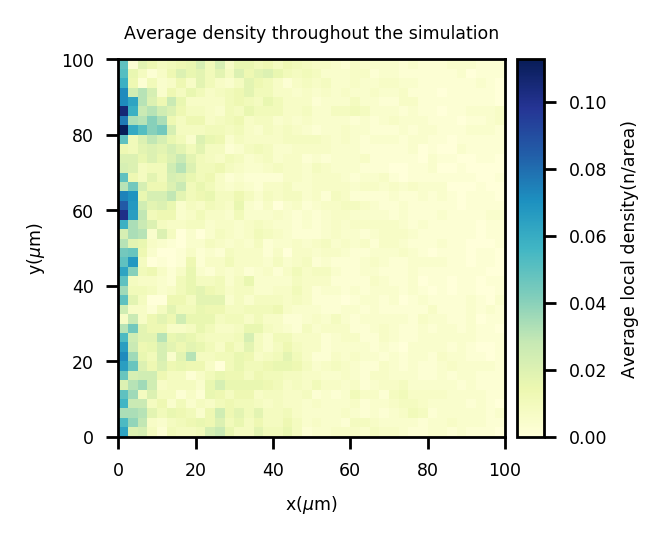

In [22]:
densityav=np.zeros([numboxes_x,numboxes_y])

densityav=density_av(x,y,xb,yb,num_steps,numboxes_x,numboxes_y)
N_maxd=np.max(densityav)                    


fig = plt.figure(figsize=(2.2,2),dpi=250)
ax = fig.add_subplot(111)

plt.xlim(right=box_x,left=0)
plt.ylim(top=box_y,bottom=0)

ax.tick_params(labelsize=mysize)
plt.xlabel('x($\mu$m)',fontsize=mysize)
plt.ylabel('y($\mu$m)',fontsize=mysize)

        
for n in range(0,numboxes_x):
    for h in range(0,numboxes_x):   
                color_c=np.int(densityav[n,h]*ncolors/N_maxd)
                fill([xb[n],xb[n+1],xb[n+1],xb[n]], [yb[h],yb[h],yb[h+1],yb[h+1]], color=colors[color_c], alpha=1,linewidth=0)

plt.title( 'Average density throughout the simulation', fontsize=mysize)      

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="7%", pad=0.05)
sm = plt.cm.ScalarMappable(cmap='YlGnBu', norm=plt.Normalize(vmin=0, vmax=N_maxd))
cbar=plt.colorbar(sm,cax=cax)
cbar.set_label(label='Average local density(n/area)', size=mysize)
cbar.ax.tick_params(labelsize=mysize)

plt.show()

## We check the distribution probability of time between tumblings

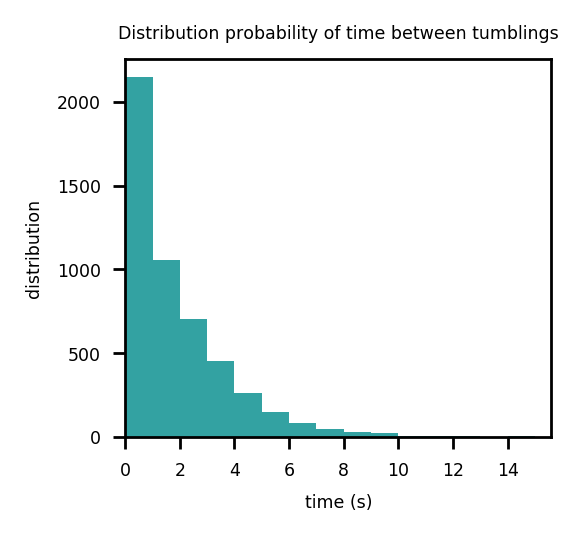

In [23]:
sizze=np.int(num_steps*v0/5.)
timet=np.zeros([N,sizze])

timet[:]=np.nan

fig = plt.figure(figsize=(2.2,2),dpi=250)
ax = fig.add_subplot(111)


for k in range(0,N):
    tt=0.
    j=0
    for i in range(0,num_steps-1):
        if theta[i,k]==theta[i+1,k]:
            tt=tt+deltat
        else:
            timet[k,j]=tt
            tt=0.
            j=j+1
            
plt.hist(timet[~np.isnan(timet)],bins=np.arange(0,max(timet[~np.isnan(timet)])),color='darkcyan',alpha=0.8)

plt.xlim(right=max(timet[~np.isnan(timet)]),left=0)
#plt.ylim(top=box_y,bottom=0)

ax.tick_params(labelsize=mysize)
plt.xlabel('time (s)',fontsize=mysize)
plt.ylabel('distribution',fontsize=mysize)

plt.title('Distribution probability of time between tumblings', fontsize=mysize)      

plt.show()



## Creates a video for the previously generated trajectories

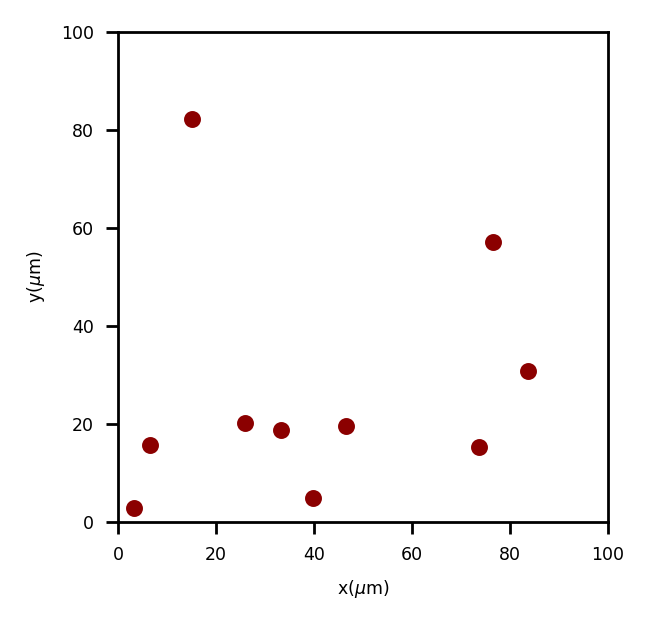

In [12]:
from matplotlib import animation
from IPython.display import HTML

fr_ps=np.int(1./deltat)

# Speed up the video:
speed=10. 

fig = plt.figure(figsize=(2.7,2.6),dpi=250)
ax = plt.axes(xlim=(0, box_x), ylim=(0, box_y)) 
scat = ax.scatter([], [], s=15, color='darkred') 
line, = ax.plot([], [], lw=2) 

#plt.title( 'Particles with $v_0$=' + str(v0) + ' $\mu$m/s, a probability of tumbling \n'
#            '$P_t=$' + str(p_s) + ' $s^{-1}$ (video speed ' + str(speed) + 'x)', fontsize=mysize)            
plt.xlabel('x($\mu$m)',fontsize=mysize)
plt.ylabel('y($\mu$m)',fontsize=mysize)
ax.tick_params(labelsize=mysize)
plt.tight_layout()


def init(): 
    # creating an empty plot/frame 
    line.set_data([], []) 
    return line, 


transpxy=np.transpose([x, y])

# animation function 
def animate(i): 
    scat.set_offsets(transpxy[:,i])
    return scat, 
    
anim = animation.FuncAnimation(fig, animate, init_func=init, 
                        frames=num_steps, interval=100/speed, blit=True) 

HTML(anim.to_html5_video())



## Save the animation as mp4 video file:

In [13]:
anim.save('run_and_tumble_vprof.mp4', writer = 'ffmpeg', fps = speed*fr_ps) 